<a href="https://colab.research.google.com/github/jmush16/Transformer-NLP-CV/blob/main/BERT_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Sentence Classification



# 1.0 Installing and Importing Dependencies

## Installing Hugging Face Transformers


In [1]:
try:
  import transformers
except:
  print("installing transformers")
  !pip install transformers

## Importing Modules

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm import tqdm, trange # using this library for progress bars
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image # using this for image rendering

## Specifying CUDA as the device for torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi
print(device)

Mon Jun 24 19:37:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 2.0 Loading the CoLA dataset

**Corpus of Linguistic Accepability(CoLA)**

"...English sentences labeled as grammatical or ungrammatical from published linguistics literature..."

[Warstadt, A., Singh, A., & Bowman, S. R. (2018). Neural Network Acceptability Judgments.](https://arxiv.org/abs/1805.12471)



[Source of the datasets](https://nyu-mll.github.io/CoLA/)

In [4]:
import requests
from PIL import Image # PIL: library used for image processing capabilities.
from io import BytesIO

def get_image_from_github(image_name):
  # The base of the image files in the Github repo
  base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/05/'

  # Make the request
  response = requests.get(base_url + image_name)

  # Check if the request was successful
  if response.status_code == 200:
    # Read the image
    image = Image.open(BytesIO(response.content))

    # return the image
    return image

  else:
    print(f"Failed to download image from {base_url + image_name}")
    return None


In [5]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0   980k      0 --:--:-- --:--:-- --:--:--  980k


In [6]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  66527      0 --:--:-- --:--:-- --:--:-- 66602


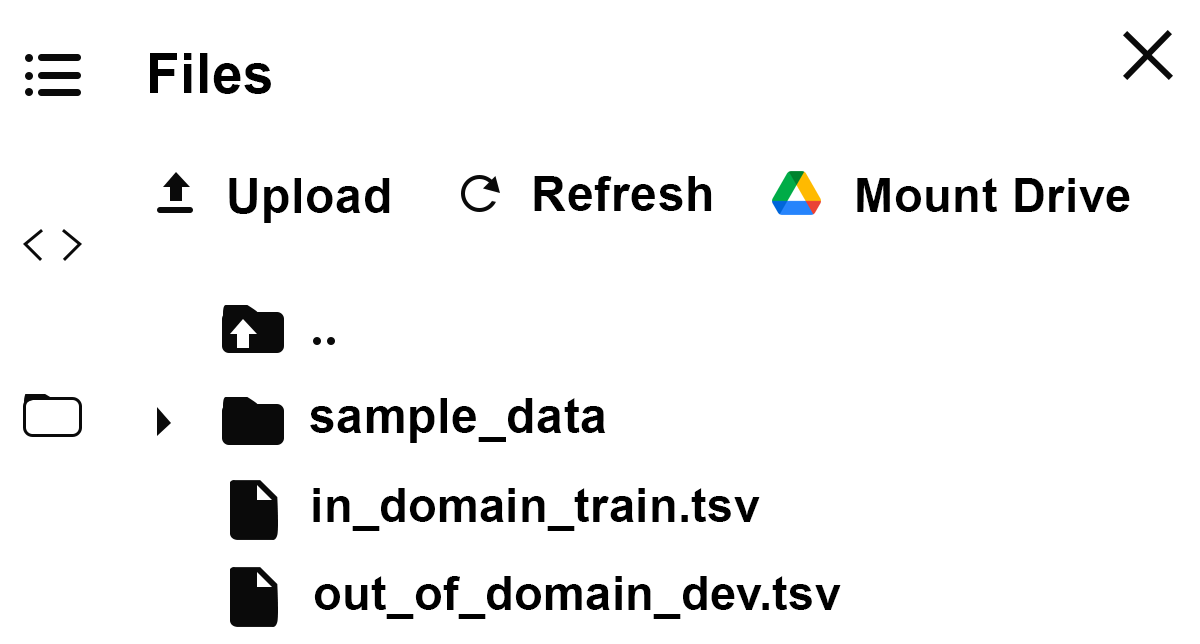

In [7]:
display(get_image_from_github('B19899_05_05.png') or print('Image not found'))

In [8]:
# source of dataset: https://nyu-mll.github.io/CoLA/

df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [10]:
# random sampling 10
df.sample(10)

,sentence_source,label,label_notes,sentence
7073,sgww85,1,NaN,you british or you americans will get yourselv...
7214,sks13,1,NaN,john told us that he wants to quit school .
2008,rhl07,1,NaN,fred threw the ball over the fence .
7430,sks13,1,NaN,"mary wo n't have been eating cake , but john w..."
2942,l-93,1,NaN,donna fixed a sandwich for me .
2704,l-93,0,*,amanda drove at the package to new york .
6614,m_02,1,NaN,the accountant was sitting at her desk .
6070,c_13,1,NaN,rory is eating muffins .
2755,l-93,0,*,gwen exchanged the dress to mary .
917,bc01,0,*,"although mag does n't eggplants , sally eats c..."


# 3.0 Creating Sentences, label lists, and adding BERT tokens

In [11]:
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] "  + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

# 4.0 Activating the BERT tokenizer

In [12]:
from transformers import BertTokenizer

try:
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  print("Tokenizer downloaded successfully")
except:
  print("An error occurred while downloading the tokenizer")
  print(str(e))
  import tracebook
  print(tracebook.format_exc())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer downloaded successfully


In [13]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence:")
print(tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


# 5.0 Processing the data

In [14]:
"""
Set the maximum sequence length. The longest sequence in our training set is 47,
but we'll leave room on the end anyway.
In the original paper, the authors used a length of 512.
"""

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocab
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 6.0 Creating Attention Masks

In [15]:
attention_masks = []

# Create a mask of 1s for each toekn following 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# 7.0 Splitting the data into training and validation sets

In [16]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# 8.0 Converting all the data into torch tensors

In [17]:
# Torch tensors are the required datatype of our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# 9.0 Selecting a batch size and creating an iterator

In [18]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 10.0 BERT model configuration

In [19]:
# Initializing a BERT-based-uncased style configuration
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



# 11.0 Loading the Hugging Face BERT uncased base model

In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

# 12.0 Optimizer grouped parameters


In [21]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the weight parameters from the bias parameters
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [22]:
# Display a sample of the parameter_optimizer: layer 3
layer_parameters = [p for n, p in model.named_parameters() if 'layer.3' in n]
print(layer_parameters)

[Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 9.7401e-02, -1.9291e-01,  4.3323e-02,  1.7938e-01, -8.0236e-02,
         2.4005e-01, -1.1202e-01, -7.8751e-02,  1.3820e-01, -2.4162e-01,
         1.9788e-01, -3.2046e-01,  3.5266e-02,  5.7152e-01, -5.9514e-02,
        -2.5558e-02,  9.7958e-02, -4.7495e-02, -2.0452e-01,  3.0384e-04,
         3.0269e-01,  4.9826e-02, -2.9197e-02,  2.3859e-01,  1.9353e-01,
         1.0818e-01,  2.7912e-01,  6.2726e-02, -1.7285e-01,  4.8728e-02,
         1.9279e-02, -6.0480e-01,  3.9

In [23]:
no_decay

['bias', 'LayerNorm.weight']

In [24]:
# Displaying the list of the two dictionaries
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

# 13.0 The hyperparameters for the training loop

In [25]:
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 14.0 The Training Loop

In [27]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4979630447769561


Epoch:  25%|██▌       | 1/4 [02:22<07:06, 142.08s/it]

Validation Accuracy: 0.7978395061728395
Train loss: 0.3073448276927857


Epoch:  50%|█████     | 2/4 [04:48<04:48, 144.39s/it]

Validation Accuracy: 0.8136574074074074
Train loss: 0.18636218582075167


Epoch:  75%|███████▌  | 3/4 [07:15<02:25, 145.66s/it]

Validation Accuracy: 0.8179012345679012
Train loss: 0.1120787659559507


Epoch: 100%|██████████| 4/4 [09:42<00:00, 145.68s/it]

Validation Accuracy: 0.8225308641975309


# 15.0 Training evaluation


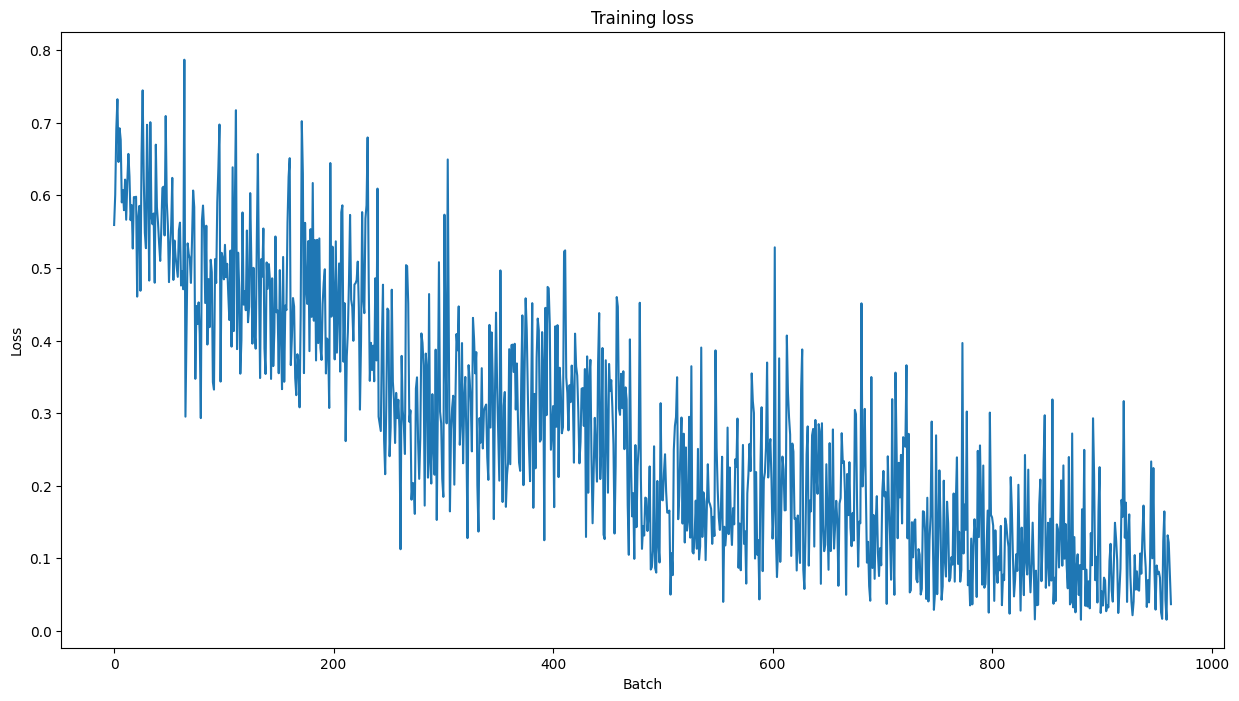

In [28]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# 16.0 Predicting and Evaluating Using the Holdout dataset

In [29]:
#loading the holdout dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])


In [30]:
df.shape

(516, 4)

In [31]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [32]:
#Softmax logits
import numpy as np

def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

In [33]:
# Put model in evaluation mode
model.eval()

# Tracking variables
raw_predictions, predicted_classes, true_labels = [], [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Convert input_ids back to words
  b_input_ids = b_input_ids.to('cpu').numpy()
  batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

  # Apply softmax function to convert logits into probabilities
  probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

  # The predicted class is the one with the highest probability
  batch_predictions = np.argmax(probabilities, axis=1)

  # Print the sentences and the corresponding predictions for this batch
  for i, sentence in enumerate(batch_sentences):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {logits[i]}")
    print(f"Sofmax probabilities", softmax(logits[i]))
    print(f"Prediction: {batch_predictions[i]}")
    print(f"True label: {label_ids[i]}")

  # Store raw predictions, predicted classes and true labels
  raw_predictions.append(logits)
  predicted_classes.append(batch_predictions)
  true_labels.append(label_ids)

Sentence: somebody just left - guess who.
Prediction: [-2.8243902  1.9761014]
Sofmax probabilities [0.00815859 0.99184144]
Prediction: 1
True label: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-2.8340719  1.95642  ]
Sofmax probabilities [0.00823991 0.9917601 ]
Prediction: 1
True label: 1
Sentence: if sam was going, sally would know where.
Prediction: [-2.9547887  2.14282  ]
Sofmax probabilities [0.00607422 0.99392575]
Prediction: 1
True label: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-3.0314176  2.1341038]
Sofmax probabilities [0.00567766 0.9943223 ]
Prediction: 1
True label: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-2.293201   1.4326932]
Sofmax probabilities [0.0235248  0.97647524]
Prediction: 1
True label: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-3.1621935  2.2257128]
Sofmax probabilities [0.00455073 0.9

# 17.0 Evaluating using the Matthews Correlation Coefficient


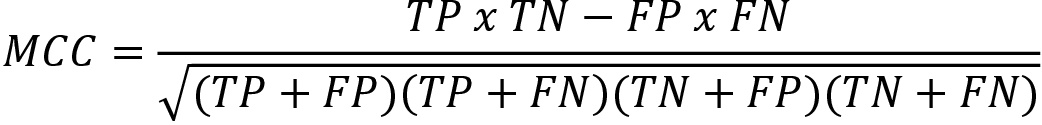

In [34]:
display(get_image_from_github('B19899_05_005.png') or print('Image not found'))

In [35]:
from sklearn.metrics import matthews_corrcoef

# Initialize an empty list to store the Matthews correlation coefficient for each batch
matthews_set = []

# Iterate over each batch
for i in range(len(true_labels)):
  # Calculate the Matthews correlation coefficient for this batch

  # true_labels[i] are the true labels for this batch
  # predicted_classes[i] are the predicted classes for this batch
  # We don't need to use np.argmax because predicted_classes already contains the predicted classes

  matthews = matthews_corrcoef(true_labels[i], predicted_classes[i])

  # Add the result to our list
  matthews_set.append(matthews)

# Now matthews_set contains the Matthews correlation coefficient for each batch

# 18.0 Matthews Correlation Coefficient evaluation for the whole dataset


In [36]:
from sklearn.metrics import matthews_corrcoef

# Flatten the true_labels and predicted_classes list of lists into single lists
true_labels_flattened = [label for batch in true_labels for label in batch]
predicted_classes_flattened = [pred for batch in predicted_classes for pred in batch]

# Calculate the MCC for the entire set of predictions
mcc = matthews_corrcoef(true_labels_flattened, predicted_classes_flattened)

print(f"MCC: {mcc}")

MCC: 0.5397916066510899


# 19.0 Saving the model

When a model is wrapped in DataParallel for multi-GPU training in PyTorch, the original model becomes an attribute of the DataParallel object.

When saving files in Google Colab, store them, as files in the Colab environment are discarded once the session ends.

The saved model can be large.


In [39]:
%cd /content/drive

/content/drive/MyDrive/Colab Notebooks/LLMs/Transformer_nlp_cv/chapter_5/model


In [ ]:
save_directory = "/content/drive

# If your model is wrapped in DataParallel, access the original model using
# .module and then save

if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(save_directory)
else:
    model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

# 20.0 Creating an inference for the trained model

In [42]:
# Standalone run

"""
Uncomment the following code if you want to run
the program in a new session after having saved the model.

You can start and continue the notebook by first running this cell and then the following ones.
"""
'''
# mount Google Drive, for example, or other source
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/model/model/

! cp drive/MyDrive/files/model_C5/*.* /content/model

#install transformers
!pip install Transformers

from transformers import BertTokenizer, BertForSequenceClassification

# Directory where the model and tokenizer were saved
load_directory = "/content/model/"

# Load the model
model = BertForSequenceClassification.from_pretrained(load_directory)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
'''

In [43]:
model.eval() # set the model to evaluation

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [44]:
def predict(sentence, model, tokenizer):
    # Add [CLS] and [SEP] tokens
    sentence = "[CLS] " + sentence + " [SEP]"
    # Tokenize the sentence
    tokenized_text = tokenizer.tokenize(sentence)

    # Convert token to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Define a segment id (0 for all tokens; we don't have a second sequence)
    segments_ids = [0] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Make prediction
    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        logits = outputs.logits
        # You might want to convert logits to probabilities or extract the predicted label.
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

# 21.0 Interacting With the Model

To begin interacting with the live classifications:

a. enter a sentence that is correct: "They went to the market."

b. then enter a sentence that is incorrect: "They no go market."

c. then try any sentence you wish to explore the scope and limitations.

Click on `Interpret` to see the explanations of an error.

Click on `Flag` to save the errors in log.csv file (see File Browser)

Click on `Clear` to enter a new sentence.

In [45]:
!pip install --upgrade typing_extensions

In [46]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00


In [47]:
import ipywidgets as widgets
from IPython.display import display

def model_predict_interface(sentence):
    prediction = predict(sentence, model, tokenizer)
    if prediction == 0:
        return "Grammatically Incorrect"
    elif prediction == 1:
        return "Grammatically Correct"
    else:
        return f"Label: {prediction}"

text_input = widgets.Textarea(
    placeholder='Type something',
    description='Sentence:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='50px')  # Adjust width and height here
)

output_label = widgets.Label(
    value='',
    layout=widgets.Layout(width='100%', height='25px'),  # Adjust width and height here
    style={'description_width': 'initial'}
)

def on_text_submit(change):
    output_label.value = model_predict_interface(change.new)

text_input.observe(on_text_submit, names='value')

display(text_input, output_label)

Textarea(value='', description='Sentence:', layout=Layout(height='50px', width='100%'), placeholder='Type some…

Label(value='', layout=Layout(height='25px', width='100%'), style=DescriptionStyle(description_width='initial'…